<a href="https://colab.research.google.com/github/weyland-zekai-xu/tutorial/blob/main/neuralmodelling_RLassigment4_Zekai_Xu.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Decision making under uncertainty

In this lecture, you learned about how the Markov decision process (MDP) framework can be extended to allow uncertainty about the states. This can be used to model a wide range of decision-making problems where there is uncertainty or noise associated with the state of the world.

We considered the example of the random dot motion discrimination task, where a subject must indicate the direction in which the majority of dots are moving. In this assignment, you will solve a two-stage formulation of this task, where the decision-maker can either make an immediate decision (i.e., at the first stage) on the basis of initial information, or choose to wait and gather further information before making their choice (i.e., at the second stage). The complete description of the problem can be found in the lecture slides and also in the original paper: http://www.gatsby.ucl.ac.uk/~dayan/papers/NDM002wc.pdf

Your task is to reproduce the plots from Figure 9 of the paper, interpret the results, and explain the steps of the solution.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

## 0. Define the parameters of the model (0.5 pts)

In [5]:
u1 = 6.
u2 = 4.

sigma1 = 1.
sigma2 = 1.

## 1. Updating the belief state  (2.5 pts)
The actual direction of motion ('state') is not completely observable to the subject. Hence, the subject can only rely on observations to compute the *belief* that the direction of motion is left or right (this is the posterior probability or 'belief state').

### 1a. Write a function that will calculate this posterior given the prior belief and an observation (the belief update). (0.5 pt)

In [2]:
from scipy.stats import norm

def update_posterior(prior, likelihood_mean, likelihood_variance, observation):
    """
    Update the posterior belief about the state of the world based on new observations.
    """

    prior_mean, prior_variance = prior

    prior_precision = 1 / prior_variance
    likelihood_precision = 1 / likelihood_variance

    # posterior
    posterior_precision = prior_precision + likelihood_precision
    posterior_variance = 1 / posterior_precision
    posterior_mean = (prior_precision * prior_mean + likelihood_precision * likelihood_mean) / posterior_precision

    return (posterior_mean, posterior_variance)



In [3]:
# test for the func

prior = (0, 1)
likelihood_mean = 1
likelihood_variance = 2
observation = 1.5

update_posterior(prior, likelihood_mean, likelihood_variance, observation)


(0.3333333333333333, 0.6666666666666666)

### 1b. Use this function to update the belief on the first observation at step $\beta$ and reproduce Fig 9A.  Interpret the plot. (1 pt)

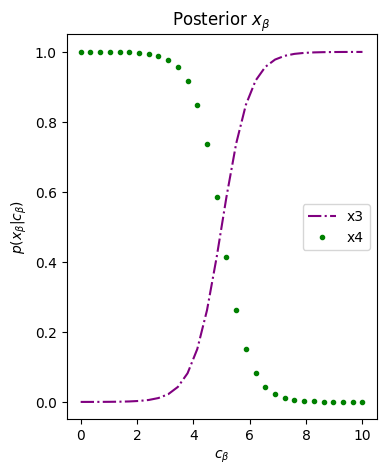

In [14]:
def belief_state_updated(c, prior, likelihood_means, likelihood_variances):
    """
    Compute the updated belief state given an observation c, a prior, and likelihood parameters.
    """
    likelihood_mean_x1, likelihood_mean_x2 = likelihood_means
    likelihood_variance_x1, likelihood_variance_x2 = likelihood_variances

    pos_x1 = update_posterior(prior, likelihood_mean_x1, likelihood_variance_x1, c)
    pos_x2 = update_posterior(prior, likelihood_mean_x2, likelihood_variance_x2, c)

    p_x1_given_c = norm.pdf(c, *pos_x1)
    p_x2_given_c = norm.pdf(c, *pos_x2)

    # normalization
    p_total = p_x1_given_c + p_x2_given_c
    p_x1_given_c /= p_total
    p_x2_given_c /= p_total

    return p_x1_given_c, p_x2_given_c

prior_belief = ((u1 + u2) / 2, 1000)

likelihood_means = (u1, u2)
likelihood_variances = (sigma1 ** 2, sigma2 ** 2)

c_list = np.linspace(0, 10, 30)

updated_beliefs = np.zeros((30, 2))
for i, c in enumerate(c_list):
    updated_beliefs[i, :] = belief_state_updated(c, prior_belief, likelihood_means, likelihood_variances)


plt.figure(figsize=(4, 5))
plt.plot(c_list, updated_beliefs[:, 0], '-.', color='purple', label="x3")
plt.plot(c_list, updated_beliefs[:, 1], '.', color='g', label="x4")
plt.xlabel(r'$c_\beta$')
plt.ylabel(r'$p(x_\beta|c_\beta)$')
plt.title(r"Posterior $x_\beta$")
plt.legend()
plt.show()



INSERT ANSWER BELOW

The plot above demonstrates the posterior distribution of $x_\beta$ given the observation value $c_\beta$. The probabilities for each state given the observation $c_\beta$ have been computed using Bayesian updating, with the assumption of a prior distribution centered between the two states with a large variance, indicating initial uncertainty. The curves intersect at 5, where probabilities are equal to 0.5, illustrating the changing belief in which state is more likely as the observation $c_\beta$ varies from zero to ten.

### 1c. Write a function to update the belief on observing another sample at step $\alpha$ and reproduce Fig 9B.  Interpret the plot. (1 pt)
Hint: You will have to calculate this probability for every possible pair of observations.

In [ ]:
c_alpha_values = np.linspace(0, 10, 50)
c_beta_values = np.linspace(0, 10, 50)

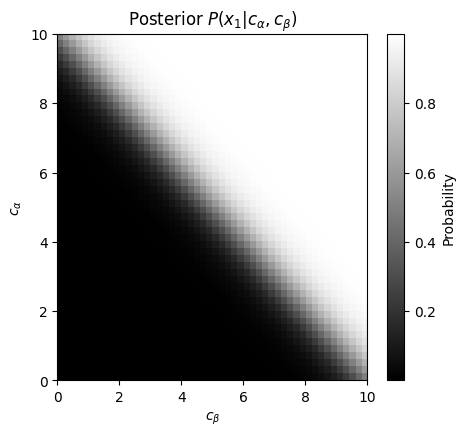

In [39]:

def update_belief_state_alpha_v2(c_alpha, c_beta, u1, u2, sigma):
    """
    Update the belief state given two observations c_alpha and c_beta.
    """
    p_c_alpha_given_x1 = norm(u1, sigma).pdf(c_alpha)
    p_c_alpha_given_x2 = norm(u2, sigma).pdf(c_alpha)
    p_c_beta_given_x3 = norm(u1, sigma).pdf(c_beta)
    p_c_beta_given_x4 = norm(u2, sigma).pdf(c_beta)

    # posterior probability of x1 given the c's at both steps
    return p_c_alpha_given_x1 * p_c_beta_given_x3 / (
        p_c_alpha_given_x1 * p_c_beta_given_x3 + p_c_alpha_given_x2 * p_c_beta_given_x4)


c_alpha_grid, c_beta_grid = np.meshgrid(c_alpha_values, c_beta_values)

belief_state_grid_v2 = np.zeros_like(c_alpha_grid)

for i in range(c_alpha_grid.shape[0]):
    for j in range(c_beta_grid.shape[1]):
        belief_state_grid_v2[i, j] = update_belief_state_alpha_v2(c_alpha_grid[i, j], c_beta_grid[i, j], u1, u2, sigma1)


plt.figure(figsize=(5, 4.5))
plt.imshow(belief_state_grid_v2, origin='lower', extent=[0, 10, 0, 10], aspect='auto', cmap='gray')
plt.xlabel(r'$c_\beta$')
plt.ylabel(r'$c_\alpha$')
plt.title(r'Posterior $P(x_1|c_\alpha, c_\beta)$')
plt.colorbar(label='Probability')
plt.show()





INSERT ANSWER BELOW

The 3D heatmap represents the posterior probability $P\left(x_1 \mid c_\alpha, c_\beta\right)$ of the state $x_1$, given two pieces of observational evidence $c_\alpha$ and $c_\beta$.


The gradient from dark to light as we move from the bottom left to the top right suggests that higher values of both $c_\alpha$ and $c_\beta$ increase the probability of being in state $x_1$ (high belief). Conversely, lower observations at both steps lead to a lower probability of being in state $x_1$, indicating that the evidence is leaning away from this state. It is pretty intuitive as $x_1 > x_2$ under the same variance. Also, the anti-diagonal line returns the most ambigious result: the belief of both states are equal (0.5).

## 2. Solving for the optimal actions (7 pts)
Now that we have a way to update the belief states, we can use them to determine the best course of action at each of the steps (the 'optimal policy').

### 2a. When finding the optimal policy, why does it make sense to calculate the best action at the final stage $\alpha$, and work backwards? (1 pt)

INSERT ANSWER BELOW

This approach makes sense because in multi-stage decision problems (here, Two-stage), the optimal policy at any stage may depend on the subsequent decisions. So by starting at the end and proceeding backwards, the agent can make a decision at each stage that accounts for the future optimal policies, which leading to an overall optimal policy.

### 2b. Write a function that will calculate the value of the best action at $\alpha$ and reproduce Fig 9C. Explain what the plot shows. (1 pt)

$V_{\alpha, c_\alpha, c_\beta}^*=\max \left\{P\left(x_1 \mid c_\alpha, c_\beta\right), P\left(x_2 \mid c_\alpha, c_\beta\right)\right\}$

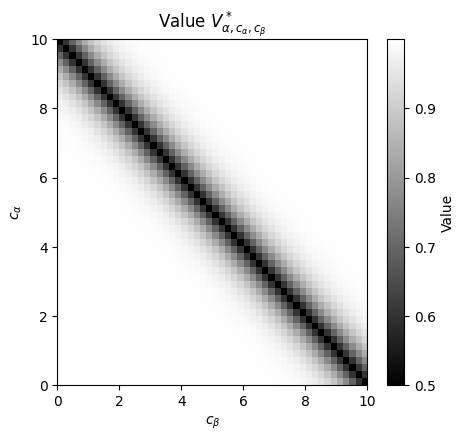

In [40]:
#value function V*

def calculate_value_function(c_alpha, c_beta, u1, u2, sigma):
    """
    Calculate the value of the best action at step alpha given observations c_alpha and c_beta.
    """
    p_c_alpha_given_x1 = norm(u1, sigma).pdf(c_alpha)
    p_c_alpha_given_x2 = norm(u2, sigma).pdf(c_alpha)
    p_c_beta_given_x3 = norm(u1, sigma).pdf(c_beta)
    p_c_beta_given_x4 = norm(u2, sigma).pdf(c_beta)

    # posterior probability of x1 given the c's at both steps
    pos_x1 = p_c_alpha_given_x1 * p_c_beta_given_x3 / (
        p_c_alpha_given_x1 * p_c_beta_given_x3 + p_c_alpha_given_x2 * p_c_beta_given_x4)

    # posterior probability of x1 given the c's at both steps
    pos_x2 = p_c_alpha_given_x2 * p_c_beta_given_x4 / (
        p_c_alpha_given_x1 * p_c_beta_given_x3 + p_c_alpha_given_x2 * p_c_beta_given_x4)

    # value function V: max of 2 postertiors
    V = max(pos_x1, pos_x2)

    return V


c_alpha_grid, c_beta_grid = np.meshgrid(c_alpha_values, c_beta_values)
value_function_grid = np.zeros_like(c_alpha_grid)


for i in range(c_alpha_grid.shape[0]):
    for j in range(c_beta_grid.shape[1]):
        value_function_grid[i, j] = calculate_value_function(c_alpha_grid[i, j], c_beta_grid[i, j], u1, u2, sigma1)


plt.figure(figsize=(5, 4.5))
plt.imshow(value_function_grid, origin='lower', extent=[0, 10, 0, 10], aspect='auto', cmap='gray')
plt.xlabel(r'$c_\beta$')
plt.ylabel(r'$c_\alpha$')
plt.title(r'Value $V^*_{\alpha,c_\alpha,c_\beta}$')
plt.colorbar(label='Value')
plt.show()

INSERT ANSWER BELOW

To calculate the optimal policy, we backward from the second state to the first. If the subject gets to $x_1$ or $x_2$, it will be able to make a choice on the basis of the observation $c_\alpha$. Given the rewards described in the paper, it will choose $\mathrm{L}$ if $P\left(x_1 \mid c_\alpha, c_\beta\right)>P\left(x_2 \mid c_\alpha, c_\beta\right)$, and $\mathrm{R}$ otherwise. Thus, the value of being at $x_\alpha$ is
$$
V_{\alpha, c_\alpha, c_\beta}^*=\max \left\{P\left(x_1 \mid c_\alpha, c_\beta\right), P\left(x_2 \mid c_\alpha, c_\beta\right)\right\} .
$$

From the plot, we can observe that the value is high (white) when $c_\alpha$ and $c_\beta$ are such that the subject can be rather sure whether $x_\alpha=x_1$ or $x_\alpha=x_2$-that is, when it can be sure which action to perform. If, instead, the cues are inconsistent, as shown in the anti-diagonal line, the value is closer to 0.5 (black), which is almost random guessing.
    

### 2c. Before finding the best action at $\beta$, we have one more step to do. We need the values of the best actions at $\alpha$ that we just calculated and the probability of observing $c_{\alpha}$ given $c_{\beta}$ ($P(c_{\alpha} | c_{\beta})$). Why? (1 pt)

INSERT ANSWER BELOW

Before deciding on the best action at $\beta$, we need to incorporate the values of the best $a$ at stage $\alpha$ because the value at $\beta$ should reflect the expected utility (V) of future decisions. The decision at $\beta$ is not just about the immediate reward or outcome; it must also take into account the expected value of subsequent ones -- a bit like Bellman equation

The probability $P\left(c_\alpha \mid c_\beta\right)$ is necessary because it provides the link between the $o$ at $\alpha$ and $\beta$. It allows us to consider the value of $a$ at $\alpha$ by the likelihood of actually observing $c_\alpha$ after observing $c_\beta$. This is important because some observations at $\alpha$ may be more likely given certain observations at $\beta$, and the optimal policy should prioritize $a$ that lead to higher expected v based on the entire trajectories $(a, o)$

### 2d. Write a function that will calculate $P(c_{\alpha} | c_{\beta})$ and reproduce Fig 9D. Explain how you calculated this probability and what the plot shows. (1 pt)
Hint: You will have to marginalise the posteriors over the possible states.

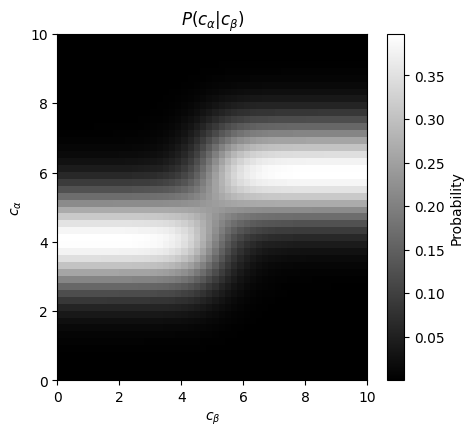

In [42]:


def calculate_conditional_probability(c_beta, u1, u2, sigma):
    """
    Calculate the conditional probability P(c_alpha | c_beta).
    """

    # marginal prob: P(c_beta)
    marginal_x1 = norm(u1, sigma).pdf(c_beta)
    marginal_x2 = norm(u2, sigma).pdf(c_beta)
    marginal_c_beta = 0.5 * (marginal_x1 + marginal_x2)

    # conditional prob P(c_alpha | x)
    conditional_x1 = norm(u1, sigma).pdf(c_alpha_values) / 2
    conditional_x2 = norm(u2, sigma).pdf(c_alpha_values) / 2

    # P(c_alpha, c_beta)
    joint_probability = conditional_x1 * marginal_x1 + conditional_x2 * marginal_x2

    return joint_probability / marginal_c_beta



conditional_probability_grid = np.zeros((len(c_alpha_values), len(c_beta_grid)))


for i, c_beta in enumerate(c_beta_grid):
    conditional_probability_grid[:, i] = calculate_conditional_probability(c_beta, u1, u2, sigma)


plt.figure(figsize=(5, 4.5))
plt.imshow(conditional_probability_grid, origin='lower', extent=[0, 10, 0, 10], aspect='auto', cmap='gray')
plt.xlabel(r'$c_\beta$')
plt.ylabel(r'$c_\alpha$')
plt.title(r'$P(c_\alpha | c_\beta)$')
plt.colorbar(label='Probability')
plt.show()


INSERT ANSWER BELOW



The plot shows the conditional probability distribution $P(c_\alpha | c_\beta)$. It indicates the likelihood of observing a particular $c_\alpha$ given that $c_\beta$ has been observed. The plot is symmetrical about the line where the means of the two states are equal (symmetry of the Gaussian). For $c_\beta=5$, we can see that the cue of the likehood of $c_alpha$ is the most ambigious: less bright in the middel vertical line. And for $c_\beta$ larger than 6 or less than 4, we can observe that the brightest lines are horizontal; otherwise (4~6), it grows in a rate of one.


### 2e. We are now ready to find the best action at $\beta$. Write a function that calculates the values associated with each of the actions and reproduce Fig 9E. What does the plot tell you about what the best action is at $\beta$? (1 pt)
Hint: For action C, you will have to numerically integrate over possible observations ${c_{\alpha}}$ using the step size ($dc_{\alpha}$) you defined on your Gaussian observation distribution.

Averaging over this distribution, we get the mean value
$$
\begin{aligned}
V_{\alpha, c_\beta}^*= & \mathbb{E}_{p\left(c_\alpha \mid c_\beta\right)}\left[V_{\alpha, c_\alpha, c_\beta}^*\right] \\
= & P\left(x_3 \mid c_\beta\right) \int_{c_\alpha} V_{\alpha, c_\alpha, c_\beta}^* p\left(c_\alpha \mid x_1\right) d c_\alpha \\
& +P\left(x_4 \mid c_\beta\right) \int_{c_\alpha} V_{\alpha, c_\alpha, c_\beta}^* p\left(c_\alpha \mid x_2\right) d c_\alpha,
\end{aligned}
$$

Then, $Q_{\beta, c_\beta}^*(\mathrm{C})=r_{c_\beta}(\mathrm{C})+V_{\alpha, c_\beta}^*=-0.1+V_{\alpha, c_\beta}^*$.

INSERT ANSWER BELOW

### 2f. What will reduce (or increase) the range of observations at $\beta$ where it is best to choose to wait for another observation (choosing C)? Can you tweak a parameter to do this and produce a plot similar to Fig 9E to show this? (2 pts)
Hint: You will have to re-run the steps with this changed parameter.

In [ ]:
# INSERT CODE BELOW

INSERT ANSWER BELOW